## Cleaning
------
### Imports

In [1]:
import pandas as pd    
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import re
import seaborn as sns
import codecs

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
from nltk.stem.snowball import SnowballStemmer 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD

import warnings
warnings.filterwarnings('ignore')


### Loading and preparing the data

In [2]:
startrek_comments = pd.read_csv('./datasets/startrek_comments.csv')
starwars_comments = pd.read_csv('./datasets/starwars_comments.csv')
startrek_submission = pd.read_csv('./datasets/startrek_submission.csv')
starwars_submission = pd.read_csv('./datasets/starwars_submission.csv')

startrek_submission = startrek_submission[['subreddit', 'selftext', 'title']]
starwars_submission = starwars_submission[['subreddit', 'selftext', 'title']]
startrek_comments = startrek_comments[['subreddit','body']]
starwars_comments = starwars_comments[['subreddit','body']]

starwars_comments['subreddit'] = starwars_comments['subreddit'].str.lower()
starwars_submission['subreddit'] = starwars_submission['subreddit'].str.lower()

comments = pd.concat([startrek_comments, starwars_comments], 
                     ignore_index=True)

submissions = pd.concat([starwars_submission, startrek_submission], 
                        ignore_index=True)



In [3]:
submissions['selftext'].fillna('', inplace=True)
#Resolving the NUll Values
# Combining the text values to one feature
submissions['all'] = submissions['selftext'] + submissions['title']
submissions.drop(['selftext', 'title'], axis=1, inplace=True)

### Regular Expressions

In [4]:
def standardize_text(df, text_field):
    # Medium : A NLP workshop by Emmanuel Ameisen (@EmmanuelAmeisen), from Insight
    # Introduced to me by Emily Naftalin, a coleague of mine.  
    df[text_field] = df[text_field].str.replace(r"removed",'')
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace('[^\w\s]',' ')
        # from James Opachich, a wine aficionado and coleague, gets rid of special characters. 
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = [re.sub(r"[\.\(\),\^\[\]\!\?\@\'\`\"\_\n]", "", df[text_field][i]) for i in df[text_field].index]
    df[text_field] = df[text_field].str.lower()

    return df

submissions = standardize_text(submissions, 'all')
comments = standardize_text(comments, 'body')

### Mapping and final checks before EDA

In [5]:
comments['subreddit'] = comments['subreddit'].map({'startrek':0,'starwars':1})
submissions['subreddit'] = submissions['subreddit'].map({'startrek':0,'starwars':1})

comments['body']=comments['body'].astype(str)
submissions['all']=submissions['all'].astype(str)



In [6]:
comments.isnull().sum()

subreddit    0
body         0
dtype: int64

In [7]:
submissions.isnull().sum()


subreddit    0
all          0
dtype: int64

In [8]:
submissions['subreddit'].value_counts()

1    2000
0    2000
Name: subreddit, dtype: int64

## EDA
-----------------------------------------------------------------------------------------

### Tokenize

Individually breaks the text up into words. 

In [9]:
# Instantiate tokenizer.
tokenizer_1 = RegexpTokenizer('\w+|\$[\d\.]+|S+')

# "Run" Tokenizer
comments['tokens'] = comments['body'].apply(tokenizer_1.tokenize)
submissions["tokens"] = submissions["all"].apply(tokenizer_1.tokenize)

In [10]:
submissions['tokens']

0       [i, ve, seen, several, novelizations, of, the,...
1       [i, posted, this, as, a, comment, in, another,...
2       [i, would, like, a, mace, windu, show, showing...
3       [1, the, ot, is, basically, reverted, the, gal...
4       [me, lili, mirojnickwho, d, you, get, to, play...
                              ...                        
3995                              [i, love, this, speech]
3996    [is, there, some, reason, that, they, can, t, ...
3997    [there, are, 791, episodes, of, star, trek, al...
3998    [when, an, unauthorized, officer, is, in, your...
3999    [preface, i, love, love, love, ds9, as, it, wa...
Name: tokens, Length: 4000, dtype: object

### Word Count

In [11]:
submissions['word_count']=[len(submissions['tokens'][i]) for i in submissions.index]

submissions.head()

,subreddit,all,tokens,word_count
0,1,i ve seen several novelizations of the main 6 ...,"[i, ve, seen, several, novelizations, of, the,...",57
1,1,i posted this as a comment in another thread ...,"[i, posted, this, as, a, comment, in, another,...",457
2,1,i would like a mace windu show showing his jou...,"[i, would, like, a, mace, windu, show, showing...",99
3,1,1 the ot is basically reverted the galaxy is...,"[1, the, ot, is, basically, reverted, the, gal...",374
4,1,me lili mirojnickwho d you get to play princes...,"[me, lili, mirojnickwho, d, you, get, to, play...",16


### Sentiment Analysis

In [12]:
sia = SentimentIntensityAnalyzer()
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

In [13]:
submissions['sentiment'] = submissions['all'].apply(get_compound_sentiment)
submissions.head()

,subreddit,all,tokens,word_count,sentiment
0,1,i ve seen several novelizations of the main 6 ...,"[i, ve, seen, several, novelizations, of, the,...",57,0.9657
1,1,i posted this as a comment in another thread ...,"[i, posted, this, as, a, comment, in, another,...",457,0.9790
2,1,i would like a mace windu show showing his jou...,"[i, would, like, a, mace, windu, show, showing...",99,0.9667
3,1,1 the ot is basically reverted the galaxy is...,"[1, the, ot, is, basically, reverted, the, gal...",374,-0.9959
4,1,me lili mirojnickwho d you get to play princes...,"[me, lili, mirojnickwho, d, you, get, to, play...",16,0.3400


### Lemmatizing & Stemming

- "He is *running* really fast!"
- "He *ran* the race."
- "He *runs* a five-minute mile."

If we wanted a computer to interpret these sentences, I might count up how many times I see each word. The computer will treat words like "running," "ran," and "runs" differently... but they mean very similar things (in this context)!

**Lemmatizing** and **stemming** are two forms of shortening words so we can combine similar forms of the same word.

When we "**lemmatize**" data, we take words and attempt to return their *lemma*, or the base/dictionary form of a word.

In [14]:
# Instantiate Lemmatizer.
lemmatizer = WordNetLemmatizer()

lem_array = []
for i in submissions.index:
    lem_list = []
    for word in submissions['tokens'][i]:
        lem_list.append(lemmatizer.lemmatize(word))
    lem_array.append(lem_list)

submissions['lems'] = lem_array

In [15]:
# Instigate PorterStemmer
p_stemmer = PorterStemmer()

# Actually screw Porter, its old, lets do snowball stemmer. 
#the snow stemmer requires a language parameter 
snow_stemmer = SnowballStemmer(language='english')


stem_array = []
for i in submissions.index:
    stem_list = []
    for word in submissions['tokens'][i]:
        stem_list.append(snow_stemmer.stem(word))
    stem_array.append(stem_list)

submissions['stems'] = stem_array

In [16]:
submissions.head()

,subreddit,all,tokens,word_count,sentiment,lems,stems
0,1,i ve seen several novelizations of the main 6 ...,"[i, ve, seen, several, novelizations, of, the,...",57,0.9657,"[i, ve, seen, several, novelization, of, the, ...","[i, ve, seen, sever, novel, of, the, main, 6, ..."
1,1,i posted this as a comment in another thread ...,"[i, posted, this, as, a, comment, in, another,...",457,0.9790,"[i, posted, this, a, a, comment, in, another, ...","[i, post, this, as, a, comment, in, anoth, thr..."
2,1,i would like a mace windu show showing his jou...,"[i, would, like, a, mace, windu, show, showing...",99,0.9667,"[i, would, like, a, mace, windu, show, showing...","[i, would, like, a, mace, windu, show, show, h..."
3,1,1 the ot is basically reverted the galaxy is...,"[1, the, ot, is, basically, reverted, the, gal...",374,-0.9959,"[1, the, ot, is, basically, reverted, the, gal...","[1, the, ot, is, basic, revert, the, galaxi, i..."
4,1,me lili mirojnickwho d you get to play princes...,"[me, lili, mirojnickwho, d, you, get, to, play...",16,0.3400,"[me, lili, mirojnickwho, d, you, get, to, play...","[me, lili, mirojnickwho, d, you, get, to, play..."


### Stop Word Removal

Removes common words that are thought to have little implication , however that is not always the case. Lets see what happens.

In [17]:
stop = stopwords.words('english')
puncts = ['!', ',', '\'', '\"', ',', "\'", '\;']
stop.extend(puncts)

stem_stop = []
for word in stop:
    stem_stop.append(snow_stemmer.stem(word))


# Print only those stemmed tokens that are different.
for a, b in zip(stem_stop, stop):
    if a != b:
        print(a + " - " + b)

our - ours
ourselv - ourselves
you'r - you're
you'v - you've
your - yours
yourselv - yourselves
she - she's
her - hers
it - it's
it - its
their - theirs
themselv - themselves
be - being
have - having
doe - does
do - doing
becaus - because
dure - during
befor - before
abov - above
onc - once
whi - why
ani - any
onli - only
veri - very
should'v - should've


In [18]:
stop_array = []

for i in submissions.index:
    
    stop_list = []
    #remove stop words from stems list. that must be done with the stems.
    
    for item in submissions['stems'][i]:
        if item not in stem_stop: # Stem_stop are the stop words inside the stems. 
            stop_list.append(item) #These are the words not stop words
    stop_array.append(stop_list) 
    
submissions['nostop_stem'] = stop_array

In [19]:
stop_array = []

for i in submissions.index:
    
    stop_list = []
    #remove stop words from lems list. that must be done with the lems.
    
    for item in submissions['lems'][i]:
        if item not in stop: # stop are the stop words. 
            stop_list.append(item) #These are the words not stop words
    stop_array.append(stop_list) 
    
submissions['nostop_lems'] = stop_array
submissions

,subreddit,all,tokens,word_count,sentiment,lems,stems,nostop_stem,nostop_lems
0,1,i ve seen several novelizations of the main 6 ...,"[i, ve, seen, several, novelizations, of, the,...",57,0.9657,"[i, ve, seen, several, novelization, of, the, ...","[i, ve, seen, sever, novel, of, the, main, 6, ...","[seen, sever, novel, main, 6, movi, never, fig...","[seen, several, novelization, main, 6, movie, ..."
1,1,i posted this as a comment in another thread ...,"[i, posted, this, as, a, comment, in, another,...",457,0.9790,"[i, posted, this, a, a, comment, in, another, ...","[i, post, this, as, a, comment, in, anoth, thr...","[post, comment, anoth, thread, kinda, got, bur...","[posted, comment, another, thread, kinda, got,..."
2,1,i would like a mace windu show showing his jou...,"[i, would, like, a, mace, windu, show, showing...",99,0.9667,"[i, would, like, a, mace, windu, show, showing...","[i, would, like, a, mace, windu, show, show, h...","[would, like, mace, windu, show, show, journey...","[would, like, mace, windu, show, showing, jour..."
3,1,1 the ot is basically reverted the galaxy is...,"[1, the, ot, is, basically, reverted, the, gal...",374,-0.9959,"[1, the, ot, is, basically, reverted, the, gal...","[1, the, ot, is, basic, revert, the, galaxi, i...","[1, ot, basic, revert, galaxi, left, reveng, s...","[1, ot, basically, reverted, galaxy, left, rev..."
4,1,me lili mirojnickwho d you get to play princes...,"[me, lili, mirojnickwho, d, you, get, to, play...",16,0.3400,"[me, lili, mirojnickwho, d, you, get, to, play...","[me, lili, mirojnickwho, d, you, get, to, play...","[lili, mirojnickwho, get, play, princess, leia...","[lili, mirojnickwho, get, play, princess, leia..."
...,...,...,...,...,...,...,...,...,...
3995,0,i love this speech,"[i, love, this, speech]",4,0.6369,"[i, love, this, speech]","[i, love, this, speech]","[love, speech]","[love, speech]"
3996,0,is there some reason that they can t replicate...,"[is, there, some, reason, that, they, can, t, ...",26,0.0000,"[is, there, some, reason, that, they, can, t, ...","[is, there, some, reason, that, they, can, t, ...","[reason, replic, technolog, futur, futur, star...","[reason, replicate, technology, future, future..."
3997,0,there are 791 episodes of star trek altogether...,"[there, are, 791, episodes, of, star, trek, al...",34,0.0000,"[there, are, 791, episode, of, star, trek, alt...","[there, are, 791, episod, of, star, trek, alto...","[791, episod, star, trek, altogeth, count, cou...","[791, episode, star, trek, altogether, countin..."
3998,0,when an unauthorized officer is in your captai...,"[when, an, unauthorized, officer, is, in, your...",26,0.6124,"[when, an, unauthorized, officer, is, in, your...","[when, an, unauthor, offic, is, in, your, capt...","[unauthor, offic, captain, chair, cute, remov,...","[unauthorized, officer, captain, chair, cute, ..."


You might be wondering why do stop words on lems and stems but not the all text feature. Turns out Cross Vectorization has stop words as a parameter so I can remove them later in the modeling process. 

## Word Frequencies

In [20]:
# Now i must pull out all the nostop_stems and combine them for each subreddit,
# then see what the most common words are in each subreddit
star_trek_stems = []
star_wars_stems = []

for i in submissions.index:

    
    #star trek = 0 , so these are all the star trek stem words. 
    if submissions['subreddit'][i] ==0:
        star_trek_stems.append(submissions['nostop_stem'][i])
    #star wars = 1 , so these are all the star wars stem words. 
    if submissions['subreddit'][i] ==1:
        star_wars_stems.append(submissions['nostop_stem'][i])
        

trek_comp = []        
for wordlist in star_trek_stems:
    w1 = ' '.join(wordlist)
    trek_comp.append(w1)
all_trek_stems = ' '.join(trek_comp)

wars_comp = []
for wordlist in star_wars_stems:
    w2 = ' '.join(wordlist)
    wars_comp.append(w2)
all_wars_stems = ' '.join(wars_comp)

In [21]:
# Now i must pull out all the nostop_lems and combine them for each subreddit,
# then see what the most common words are in each subreddit
star_trek_lems = []
star_wars_lems = []

for i in submissions.index:

    
    #star trek = 0 , so these are all the star trek stem words. 
    if submissions['subreddit'][i] ==0:
        star_trek_lems.append(submissions['nostop_lems'][i])
    #star wars = 1 , so these are all the star wars stem words. 
    if submissions['subreddit'][i] ==1:
        star_wars_lems.append(submissions['nostop_lems'][i])
        

trek_comp = []        
for wordlist in star_trek_lems:
    w1 = ' '.join(wordlist)
    trek_comp.append(w1)
all_trek_lems = ' '.join(trek_comp)

wars_comp = []
for wordlist in star_wars_lems:
    w2 = ' '.join(wordlist)
    wars_comp.append(w2)
all_wars_lems = ' '.join(wars_comp)

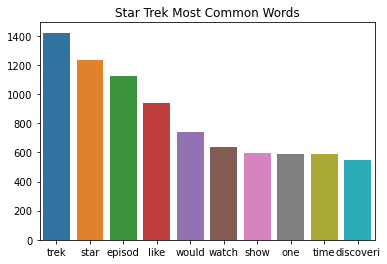

In [22]:
tokens = nltk.tokenize.word_tokenize(all_trek_stems)
freqs = FreqDist(tokens).most_common(10)

x= [x[0] for x in freqs]
y= [x[1] for x in freqs]


sns.barplot(x=x, y=y).set_title("Star Trek Most Common Words");
plt.savefig('./images/startrek_10common.png')

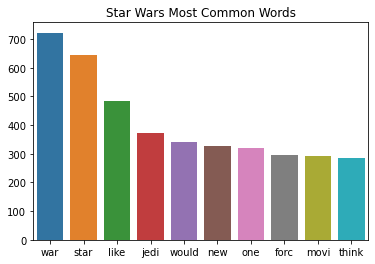

In [23]:
tokens = nltk.tokenize.word_tokenize(all_wars_stems)
freqs = FreqDist(tokens).most_common(10)

x= [x[0] for x in freqs]
y= [x[1] for x in freqs]

sns.barplot(x=x, y=y).set_title("Star Wars Most Common Words");
plt.savefig('./images/starwars_10common.png')

These are the stem words, excluding the stopped words, that are most common in star trek and star wars respectivly.
It is time to look at this another way. Let's transform our data and find the words with the highest coorelations to their classes and go from there. 


### Visualizing the embeddings
Now that we've created embeddings, let's visualize them and see if we can identify some structure. In a perfect world, our embeddings would be so distinct that are two classes would be perfectly separated. Since visualizing data in 20k dimensions is hard, let's project it down to 2.

In [24]:
X = submissions[['all', 'word_count','sentiment']]
y = submissions['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [25]:
cv = CountVectorizer(min_df=0.01, stop_words='english')
XX_train_counts = cv.fit_transform(X_train['all'])
XX_test_counts = cv.transform(X_test['all'])

datafrog = pd.DataFrame(XX_train_counts.todense(), columns=cv.get_feature_names())

In [26]:
datafrog;

In [27]:
SVD = TruncatedSVD(n_components=10)
svd_matrix = SVD.fit_transform(datafrog)
svd_matrix.shape

(3200, 10)

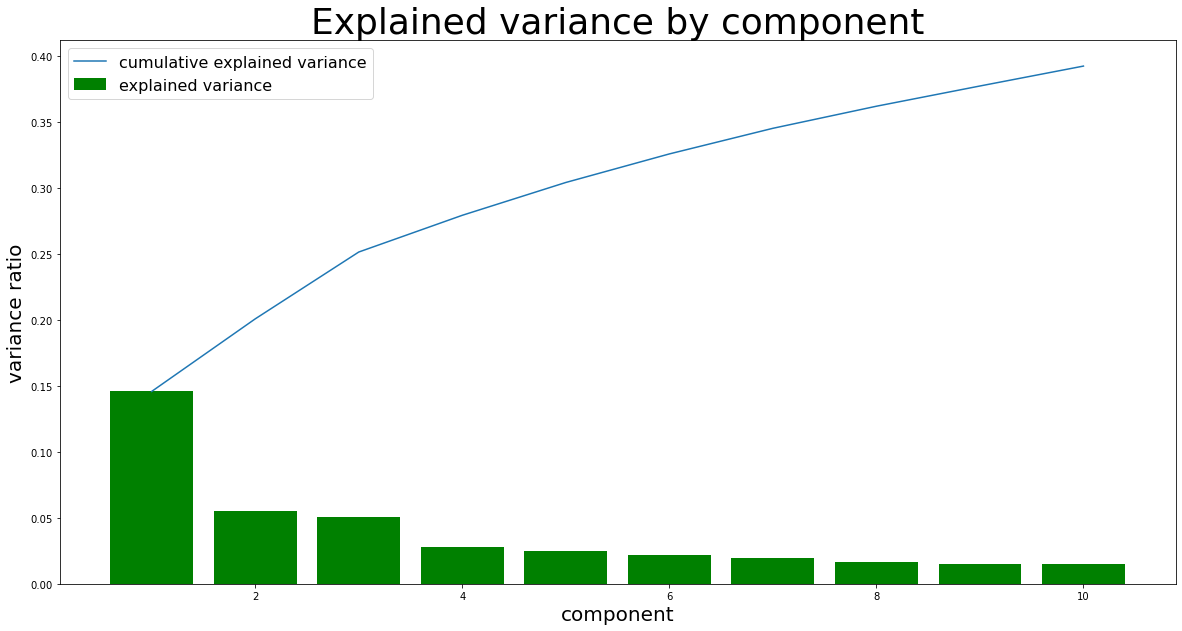

In [28]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(10))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(10))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend(fontsize=16)
plt.xlabel('component', fontsize=20)
plt.ylabel('variance ratio', fontsize=20)
plt.title('Explained variance by component', fontsize=36)
plt.savefig('./images/explained_variance.png')

In [29]:
component_names = ["component_"+str(i+1) for i in range(10)]
svd_df = pd.DataFrame(svd_matrix,
                      columns=component_names)

In [30]:
loadings = pd.DataFrame(SVD.components_,
                        index=component_names,
                        columns=datafrog.columns).T
loadings.shape

(424, 10)

In [31]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)

In [32]:
loadings.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,abs_component_1,abs_component_2
10,0.036529,0.023149,-0.008781,-0.067562,0.120813,0.498025,0.433721,-0.389388,0.501589,0.093256,0.036529,0.023149
12,0.009164,0.017831,0.002679,-0.004249,0.019823,0.035835,0.020053,0.022437,-0.036334,-0.009875,0.009164,0.017831
2020,0.014771,-0.004710,0.022221,-0.007002,0.003609,0.012176,-0.008210,-0.008817,-0.032704,0.025988,0.014771,0.004710
2021,0.002554,-0.000370,0.003040,-0.001608,0.002411,0.002006,0.002279,-0.006148,0.001492,-0.000167,0.002554,0.000370
able,0.016515,-0.004855,-0.015596,0.018026,0.008452,0.000148,-0.009079,0.004945,-0.006885,-0.001585,0.016515,0.004855


In [33]:
loadings.sort_values('abs_component_1',ascending=False).head(20)[['component_1']]

,component_1
star,0.348053
trek,0.309315
episode,0.301846
like,0.276898
just,0.264984
episodes,0.153148
time,0.148224
season,0.147918
think,0.142694
series,0.140302


In [34]:
loadings.sort_values('abs_component_2',ascending=False).head(20)[['component_1']]

,component_1
episode,0.301846
star,0.348053
episodes,0.153148
wars,0.098876
season,0.147918
force,0.068774
like,0.276898
luke,0.066525
jedi,0.061265
michael,0.050352


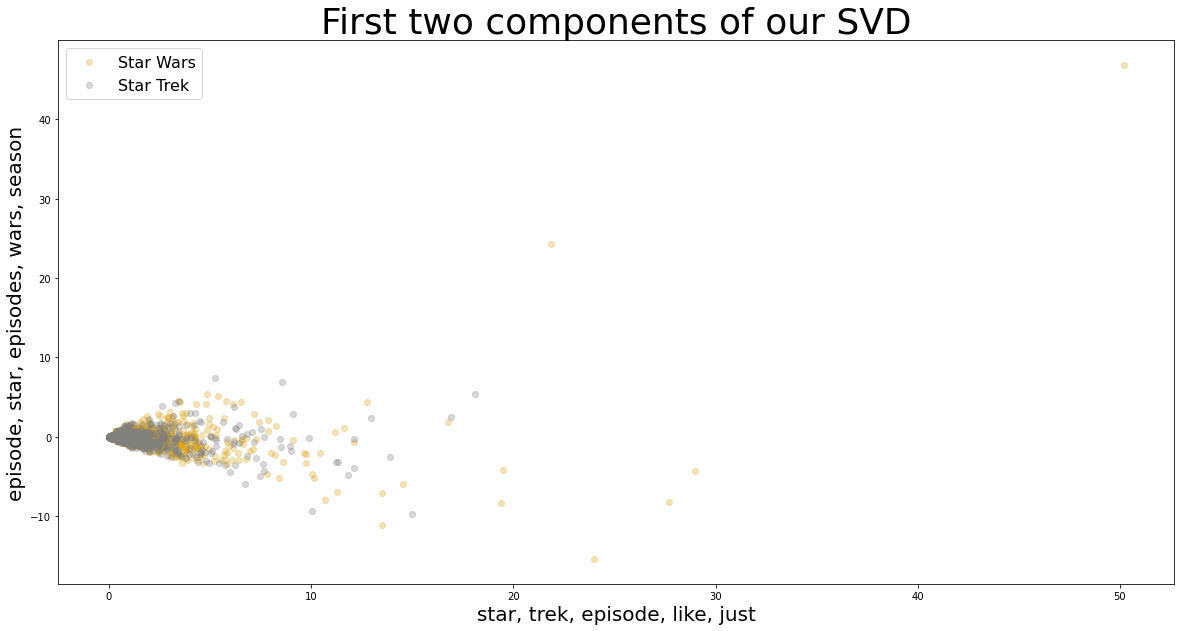

In [35]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df.component_1[submissions['subreddit']==1], svd_df.component_2[submissions['subreddit']==1], c='goldenrod', alpha=.3)
plt.scatter(svd_df.component_1[submissions['subreddit']==0], svd_df.component_2[submissions['subreddit']==0], c='grey', alpha=.3)
plt.xlabel(f"{', '.join(loadings.sort_values('abs_component_1',ascending=False).head(5)[['component_1']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('abs_component_2',ascending=False).head(5)[['component_2']].index)}",
          fontsize=20)
plt.title('First two components of our SVD', fontsize=36)
plt.legend(['Star Wars', 'Star Trek'], fontsize=16)
plt.savefig('./images/components.png')

--------------------------

In [36]:
submissions.to_pickle('./datasets/submissions.pkl')
comments.to_pickle('./datasets/comments.pkl')